In [1]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
from pyproj import Geod
from tqdm import tqdm

# Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [2]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"
intermediate_results_path = BASE_DIR / 'intermediate_results'

In [3]:
gdf_hazards = gpd.read_parquet(intermediate_results_path / "main_network_hazard_exposure.parquet") 
base_network = gpd.read_parquet(intermediate_results_path / 'PERS_directed_final.parquet')

In [4]:
hospital_exposed_edges = gpd.read_parquet(intermediate_results_path / 'hospital_impacts.parquet').to_crs(gdf_hazards.crs)
factory_exposed_edges = gpd.read_parquet(intermediate_results_path / 'factory_impacts.parquet').to_crs(gdf_hazards.crs)
police_exposed_edges = gpd.read_parquet(intermediate_results_path / 'police_impacts.parquet').to_crs(gdf_hazards.crs)
fire_exposed_edges = gpd.read_parquet(intermediate_results_path / 'fire_impacts.parquet').to_crs(gdf_hazards.crs)
border_exposed_edges = gpd.read_parquet(intermediate_results_path / 'road_impacts.parquet').to_crs(gdf_hazards.crs)
port_exposed_edges = gpd.read_parquet(intermediate_results_path / 'port_impacts.parquet').to_crs(gdf_hazards.crs)
railway_exposed_edges = gpd.read_parquet(intermediate_results_path / 'rail_impacts.parquet').to_crs(gdf_hazards.crs)

In [5]:
future_flood_change_rp =  gpd.read_parquet(intermediate_results_path / 'Future Floods change in RP.parquet').to_crs(gdf_hazards.crs)
future_rainfall_change =  gpd.read_parquet(intermediate_results_path / 'change in maximum daily precipitation rcp 85 period 2.paquet').to_crs(gdf_hazards.crs)

In [6]:
def add_impact_column(base_gdf, edges_gdf, impact_col_name, predicate="intersects", agg="mean", col_to_focus = 'travel_time_impact'):
    """
    Spatially join edges to base_gdf, aggregate travel_time_impact per base index, and add as a new column.
    - predicate: 'intersects', 'within', 'contains', 'touches' (choose based on geometry semantics)
    - agg: 'mean', 'max', 'min', 'median' etc.
    """
    # Keep only needed columns to avoid bloat
    edges = edges_gdf[[col_to_focus, 'geometry']].copy()

    # Spatial join (left frame is base), this creates potential many-to-one matches
    joined = base_gdf.sjoin(edges, how='left', predicate=predicate)

    # Aggregate per left index (hazard_id)
    # Note: joined.index is the left index; the sjoin adds right index as 'index_right'
    agg_series = joined.groupby(joined.index)[col_to_focus].agg(agg)

    # Attach to base_gdf with a clear name
    base_gdf[impact_col_name] = agg_series.reindex(base_gdf.index)

    return base_gdf

# Add each impact column (choose your aggregator: 'mean' or 'max')
gdf_hazards = add_impact_column(gdf_hazards, hospital_exposed_edges, 'hospital_delay', predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, factory_exposed_edges,  'factory_delay',  predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, police_exposed_edges,   'police_delay',   predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, fire_exposed_edges,     'fire_delay',     predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, port_exposed_edges,  'port_delay',  predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, border_exposed_edges,   'border_delay',   predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, railway_exposed_edges,     'railway_delay',     predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, future_flood_change_rp,   'future_flood_change',   predicate='intersects', agg='mean',col_to_focus='rp30_mean')
gdf_hazards = add_impact_column(gdf_hazards, future_rainfall_change,     'future_rainfall_change',     predicate='intersects', agg='mean',col_to_focus='max_rx1day_pct')

In [7]:
# =============================================================================
# CLIMATE CRITICALITY METRIC - UPDATED METHODOLOGY
# =============================================================================

# Ensure gdf_hazards has a stable index
gdf_hazards = gdf_hazards.copy()
gdf_hazards.index.name = 'section_id'

# -----------------------------------------------------------------------------
# 1. PREPARE DATA - Rename columns to standard names
# -----------------------------------------------------------------------------

gdf_hazards = gdf_hazards.rename(columns={
    'max_depth': 'flood_depth',
    'dužina_sn': 'snow_drift',
    'datum_evid': 'landslide_date',
    # Add any other renames as needed
})

# Convert landslide_date to binary presence indicator
gdf_hazards['landslide_exposure'] = np.where(
    gdf_hazards['landslide_date'].astype(str).str.len() > 0, 1.0, 0.0
)

# -----------------------------------------------------------------------------
# 2. DEFINE METRIC GROUPS FOR EACH SUB-INDEX
# -----------------------------------------------------------------------------

# Hazard Exposure Sub-Index (H) - 5 metrics
hazard_metrics = [
    'flood_depth',              # F - Maximum inundation depth (cm)
    'future_rainfall_change',   # R - Projected % change in extreme rainfall
    'future_flood_change',      # C - Projected % change in river flood magnitude
    'landslide_exposure',       # L - Binary landslide exposure
    'snow_drift'                # S - Length affected by snow drift (km)
]

# National-Scale Travel Disruption Sub-Index (T) - 4 metrics
travel_metrics = [
    'phl',  # Passenger hours lost
    'thl',  # Tonnage hours lost
    'pkl',  # Passenger kilometers lost
    'tkl'   # Tonnage kilometers lost
]

# Local Accessibility Sub-Index (A) - 6 metrics
accessibility_metrics = [
    'hospital_delay',      # HOS - Hospital access delay
    'fire_delay',          # FIR - Fire station access delay
    'police_delay',        # POL - Police station access delay
    'port_delay',          # PRT - Port access delay (agriculture)
    'border_delay',        # BRD - Border crossing delay (agriculture/industry)
    'railway_delay'        # RWY - Railway station access delay (agriculture)
]

# All metrics combined
all_metrics = hazard_metrics + travel_metrics + accessibility_metrics

In [8]:
# -----------------------------------------------------------------------------
# 3. ENSURE ALL COLUMNS EXIST AND HANDLE MISSING VALUES
# -----------------------------------------------------------------------------

for col in all_metrics:
    if col not in gdf_hazards.columns:
        print(f"Warning: Column '{col}' not found. Creating with zeros.")
        gdf_hazards[col] = 0.0
    # Convert to float and fill NaN with 0
    gdf_hazards[col] = gdf_hazards[col].astype(float).fillna(0.0)


In [9]:
# -----------------------------------------------------------------------------
# 4. MIN-MAX NORMALIZATION FUNCTION
# -----------------------------------------------------------------------------

def safe_minmax_normalize(series):
    """
    Normalize a series to [0, 1] using min-max normalization.
    Returns zeros if constant or all missing.
    """
    s = series.astype(float).fillna(0.0)
    min_val = s.min()
    max_val = s.max()
    
    if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
        return pd.Series(np.zeros(len(s)), index=s.index)
    
    return (s - min_val) / (max_val - min_val)

# -----------------------------------------------------------------------------
# 5. NORMALIZE ALL METRICS
# -----------------------------------------------------------------------------

print("Normalizing metrics...")

for col in all_metrics:
    norm_col = f'{col}_norm'
    gdf_hazards[norm_col] = safe_minmax_normalize(gdf_hazards[col])
    print(f"  {col}: min={gdf_hazards[col].min():.2f}, max={gdf_hazards[col].max():.2f}")

# -----------------------------------------------------------------------------
# 6. COMPUTE SUB-INDICES (Equal weights within each sub-index)
# -----------------------------------------------------------------------------

# Normalized column names
hazard_norm = [f'{col}_norm' for col in hazard_metrics]
travel_norm = [f'{col}_norm' for col in travel_metrics]
accessibility_norm = [f'{col}_norm' for col in accessibility_metrics]

# Hazard Exposure Sub-Index: H = (1/5) × (F + R + C + L + S)
gdf_hazards['H_hazard_exposure'] = gdf_hazards[hazard_norm].mean(axis=1)

# National-Scale Travel Disruption Sub-Index: T = (1/4) × (PHL + THL + PKL + TKL)
gdf_hazards['T_travel_disruption'] = gdf_hazards[travel_norm].mean(axis=1)

# Local Accessibility Sub-Index: A = (1/6) × (HOS + FIR + POL + PRT + BRD + RWY)
gdf_hazards['A_local_accessibility'] = gdf_hazards[accessibility_norm].mean(axis=1)

# -----------------------------------------------------------------------------
# 7. COMPUTE COMBINED CLIMATE CRITICALITY (Equal weights across sub-indices)
# -----------------------------------------------------------------------------

# CC = (1/3) × (H + T + A)
sub_indices = ['H_hazard_exposure', 'T_travel_disruption', 'A_local_accessibility']
gdf_hazards['CC_climate_criticality'] = gdf_hazards[sub_indices].sum(axis=1)

# -----------------------------------------------------------------------------
# 8. CLASSIFY INTO QUINTILES (5 categories based on 20% quantiles)
# -----------------------------------------------------------------------------

def classify_quintiles(series, labels=None):
    if labels is None:
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    
    # Create an empty series to store results
    result = pd.Series(index=series.index, dtype='object')
    
    # 1. Identify zeros and assign "No criticality"
    is_zero = (series == 0)
    result[is_zero] = 'No criticality'
    
    # 2. Isolate non-zero values for quintile calculation
    non_zeros = series[~is_zero]
    
    if not non_zeros.empty:
        # Use qcut directly on non-zero values to ensure equal-sized bins
        # duplicates='drop' handles cases with many identical non-zero values
        quintiles = pd.qcut(non_zeros, 5, labels=labels, duplicates='drop')
        result[~is_zero] = quintiles
        
    return result

# Classify each sub-index
gdf_hazards['H_class'] = classify_quintiles(gdf_hazards['H_hazard_exposure'])
gdf_hazards['T_class'] = classify_quintiles(gdf_hazards['T_travel_disruption'])
gdf_hazards['A_class'] = classify_quintiles(gdf_hazards['A_local_accessibility'])

# Classify combined score
gdf_hazards['CC_class'] = classify_quintiles(gdf_hazards['CC_climate_criticality'])



Normalizing metrics...
  flood_depth: min=0.00, max=54.62
  future_rainfall_change: min=-0.63, max=20.81
  future_flood_change: min=0.00, max=117.43
  landslide_exposure: min=1.00, max=1.00
  snow_drift: min=0.00, max=26.48
  phl: min=0.00, max=113798.36
  thl: min=0.00, max=77008.86
  pkl: min=0.00, max=1629760.76
  tkl: min=0.00, max=1225302.16
  hospital_delay: min=0.00, max=1.25
  fire_delay: min=0.00, max=1.09
  police_delay: min=0.00, max=1.11
  port_delay: min=0.00, max=1.41
  border_delay: min=0.00, max=1.89
  railway_delay: min=0.00, max=1.66


In [10]:
gdf_hazards['H_class']

section_id
4       Very High
6             Low
10      Very High
13            Low
23       Very Low
          ...    
3124          Low
3126    Very High
3127     Very Low
3128    Very High
3129     Very Low
Name: H_class, Length: 1258, dtype: object

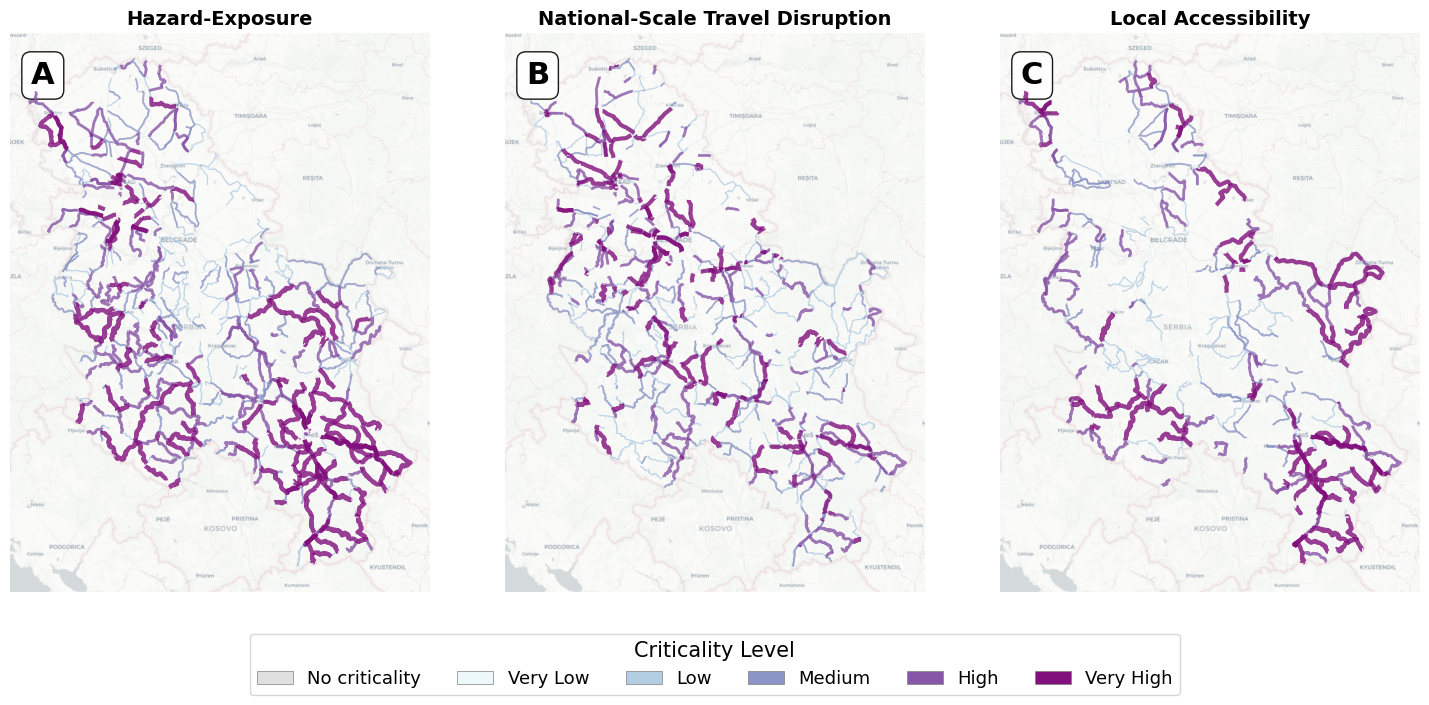

In [11]:
# =============================================================================
# 2. Configuration: Colors, Labels, and Widths
# =============================================================================
class_cols = ['H_class','T_class','A_class']
labels = ['No criticality', 'Very Low', 'Low', 'Medium', 'High', 'Very High']
colors = ['#e0e0e0', '#edf8fb','#b3cde3','#8c96c6','#8856a7','#810f7c']
color_map = dict(zip(labels, colors))

width_mapping = {
    'No criticality': 0.2,
    'Very Low': 0.6,
    'Low': 0.9,
    'Medium': 1.3,
    'High': 2.0,
    'Very High': 3.0
}

# Ensure CRS is Web Mercator for contextily
gdf_hazards = gdf_hazards.to_crs(epsg=3857)

# =============================================================================
# 4. Plotting Function and Figure Generation
# =============================================================================

def plot_panel(ax, gdf, class_col, letter, title):
    # Optional: Plot background network if you have one
    # base_network.plot(ax=ax, linewidth=0.1, color='lightgrey', alpha=0.5)
    
    # Plot each category in specific order (lowest to highest) 
    # so high criticality is on top
    for cat in labels:
        subset = gdf[gdf[class_col] == cat]
        if not subset.empty:
            subset.plot(
                ax=ax, 
                color=color_map[cat], 
                linewidth=width_mapping[cat],
                alpha=0.8 if cat != 'No criticality' else 0.4,
                zorder=labels.index(cat) # Higher criticality on top
            )
    
    # Add Basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False)
    
    # UI Elements
    ax.axis('off')
    ax.text(0.05, 0.95, letter, transform=ax.transAxes, fontsize=22, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
    ax.set_title(title, fontsize=14,fontweight='bold')

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

titles = ['Hazard-Exposure', 'National-Scale Travel Disruption', 'Local Accessibility']

# Loop through the axes and classification columns
for i, ax in enumerate(axes):
    plot_panel(axes[i], gdf_hazards, class_cols[i], chr(65+i), titles[i])

# =============================================================================
# 5. Shared Legend
# =============================================================================

legend_handles = [
    Patch(facecolor=color_map[lbl], label=lbl, edgecolor='grey', linewidth=0.5)
    for lbl in labels
]

fig.legend(
    handles=legend_handles,
    title='Criticality Level',
    loc='lower center',
    bbox_to_anchor=(0.5, 0.02),
    ncol=6,
    fontsize=13,
    title_fontsize=15,
    frameon=True
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)

# Save or show
plt.savefig(figure_path / 'criticality_analysis_3panel.png', dpi=300, bbox_inches='tight')
plt.show()

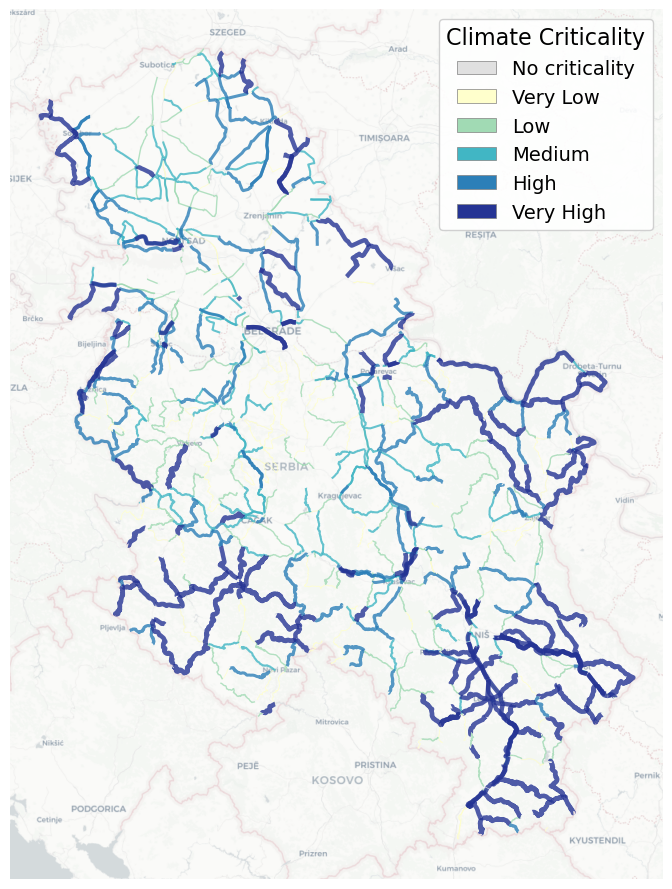

In [12]:
# =============================================================================
# CLIMATE CRITICALITY - SINGLE FIGURE (Mean)
# =============================================================================

# Calculate mean criticality
norm_cols = ['H_hazard_exposure', 'T_travel_disruption', 'A_local_accessibility']
gdf_hazards['criticality_mean'] = gdf_hazards[norm_cols].mean(axis=1)

# Classification function
def classify_quintiles(series, labels=None):
    if labels is None:
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    result = pd.Series('No criticality', index=series.index)
    non_zero_mask = series > 0
    non_zeros = series[non_zero_mask]
    
    if not non_zeros.empty:
        bins = pd.qcut(non_zeros, 5, labels=labels, duplicates='drop')
        result[non_zero_mask] = bins.astype(str)
    return result

# Apply classification
gdf_hazards['mean_class'] = classify_quintiles(gdf_hazards['criticality_mean'])

# Ensure Web Mercator for plotting
gdf_hazards = gdf_hazards.to_crs(epsg=3857)

# Visualization configuration
labels = ['No criticality', 'Very Low', 'Low', 'Medium', 'High', 'Very High']
colors = ['#e0e0e0', '#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
color_map = dict(zip(labels, colors))
width_mapping = {
    'No criticality': 0.2, 'Very Low': 0.6, 'Low': 1.0, 
    'Medium': 1.5, 'High': 2.2, 'Very High': 3.2
}

# Create single figure
fig, ax = plt.subplots(1, 1, figsize=(7, 9))

# Plot each category
for cat in labels:
    subset = gdf_hazards[gdf_hazards['mean_class'] == cat]
    if not subset.empty:
        subset.plot(
            ax=ax, 
            color=color_map[cat], 
            linewidth=width_mapping[cat],
            alpha=0.8 if cat != 'No criticality' else 0.4,
            zorder=labels.index(cat)
        )

# Add basemap and remove axes
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, attribution=False)
ax.axis('off')

# Legend
legend_handles = [
    Patch(facecolor=color_map[lbl], label=lbl, edgecolor='grey', linewidth=0.5)
    for lbl in labels
]

ax.legend(
    handles=legend_handles,
    title='Climate Criticality',
    loc='upper right',
    fontsize=14,
    title_fontsize=16,
    frameon=True,
    framealpha=0.9
)

plt.tight_layout()
plt.savefig(figure_path / 'climate_criticality_mean.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# =============================================================================
# CLIMATE CRITICALITY - SUMMARY STATISTICS
# =============================================================================

print("="*80)
print("CLIMATE CRITICALITY SUMMARY STATISTICS")
print("="*80)

# Define classification columns
class_cols = ['H_class', 'T_class', 'A_class', 'mean_class']
class_names = ['Hazard Exposure', 'Travel Disruption', 'Local Accessibility', 'Combined Criticality']
index_cols = ['H_hazard_exposure', 'T_travel_disruption', 'A_local_accessibility', 'criticality_mean']

# =============================================================================
# 1. OVERALL DISTRIBUTION BY CRITICALITY CLASS
# =============================================================================

print("\n" + "="*80)
print("1. OVERALL DISTRIBUTION BY CRITICALITY CLASS")
print("="*80)

labels = ['No criticality', 'Very Low', 'Low', 'Medium', 'High', 'Very High']

for class_col, class_name in zip(class_cols, class_names):
    print(f"\n{class_name}:")
    print("-"*50)
    counts = gdf_hazards[class_col].value_counts()
    total = len(gdf_hazards)
    for label in labels:
        if label in counts.index:
            count = counts[label]
            pct = count / total * 100
            print(f"  {label:15s}: {count:5d} ({pct:5.1f}%)")
        else:
            print(f"  {label:15s}: {0:5d} ({0:5.1f}%)")

# =============================================================================
# 2. CRITICALITY BY ROAD CATEGORY
# =============================================================================

print("\n" + "="*80)
print("2. CRITICALITY BY ROAD CATEGORY")
print("="*80)

# Cross-tabulation: Road category vs Criticality class
for class_col, class_name in zip(class_cols, class_names):
    print(f"\n{class_name} by Road Category:")
    print("-"*60)
    
    # Create cross-tab with percentages
    ct = pd.crosstab(gdf_hazards['kategorija'], gdf_hazards[class_col], normalize='index') * 100
    
    # Reorder columns
    ct = ct.reindex(columns=[l for l in labels if l in ct.columns])
    
    print(ct.round(1).to_string())

# =============================================================================
# 3. MEAN CRITICALITY SCORES BY ROAD CATEGORY
# =============================================================================

print("\n" + "="*80)
print("3. MEAN CRITICALITY SCORES BY ROAD CATEGORY")
print("="*80)

road_summary = gdf_hazards.groupby('kategorija').agg({
    'H_hazard_exposure': ['count', 'mean', 'median', 'max'],
    'T_travel_disruption': ['mean', 'median', 'max'],
    'A_local_accessibility': ['mean', 'median', 'max'],
    'criticality_mean': ['mean', 'median', 'max']
}).round(4)

print(road_summary.to_string())

# =============================================================================
# 4. HIGH-TIER vs LOW-TIER ROADS COMPARISON
# =============================================================================

print("\n" + "="*80)
print("4. HIGH-TIER vs LOW-TIER ROADS COMPARISON")
print("="*80)

# Define road tiers
high_tier = ['IA', 'IM', 'IB']  # Motorways and main roads
low_tier = ['IIA', 'IIB']       # Regional roads

gdf_hazards['road_tier'] = np.where(
    gdf_hazards['kategorija'].isin(high_tier), 'High-Tier (IA/IM/IB)',
    np.where(gdf_hazards['kategorija'].isin(low_tier), 'Low-Tier (IIA/IIB)', 'Other')
)

# Compare mean scores
print("\nMean Criticality Scores by Road Tier:")
print("-"*60)
tier_summary = gdf_hazards.groupby('road_tier')[index_cols].mean().round(4)
print(tier_summary.to_string())

# Compare distribution of criticality classes
print("\n\nCombined Criticality Distribution by Road Tier (%):")
print("-"*60)
tier_ct = pd.crosstab(gdf_hazards['road_tier'], gdf_hazards['mean_class'], normalize='index') * 100
tier_ct = tier_ct.reindex(columns=[l for l in labels if l in tier_ct.columns])
print(tier_ct.round(1).to_string())

# Statistical test (if needed)
from scipy import stats
high_tier_scores = gdf_hazards[gdf_hazards['road_tier'] == 'High-Tier (IA/IM/IB)']['criticality_mean']
low_tier_scores = gdf_hazards[gdf_hazards['road_tier'] == 'Low-Tier (IIA/IIB)']['criticality_mean']

if len(high_tier_scores) > 0 and len(low_tier_scores) > 0:
    stat, pvalue = stats.mannwhitneyu(high_tier_scores, low_tier_scores, alternative='two-sided')
    print(f"\nMann-Whitney U test (High-Tier vs Low-Tier):")
    print(f"  U-statistic: {stat:.2f}")
    print(f"  p-value: {pvalue:.6f}")
    print(f"  Significant difference: {'Yes' if pvalue < 0.05 else 'No'}")

# =============================================================================
# 5. TOP 10 MOST CRITICAL SECTIONS (COMBINED)
# =============================================================================

print("\n" + "="*80)
print("5. TOP 10 MOST CRITICAL SECTIONS (Combined Criticality)")
print("="*80)

top_cols = ['oznaka_deo', 'kategorija', 'oznaka_put', 'naziv_poce', 'naziv_zavr',
            'H_hazard_exposure', 'T_travel_disruption', 'A_local_accessibility', 
            'criticality_mean', 'mean_class']
top_cols = [c for c in top_cols if c in gdf_hazards.columns]

top10_combined = gdf_hazards.nlargest(10, 'criticality_mean')[top_cols]
print(top10_combined.to_string())

# =============================================================================
# 6. TOP 5 PER SUB-INDEX
# =============================================================================

print("\n" + "="*80)
print("6. TOP 5 SECTIONS PER SUB-INDEX")
print("="*80)

for index_col, class_name in zip(index_cols[:3], class_names[:3]):
    print(f"\n{class_name} - Top 5:")
    print("-"*60)
    display_cols = ['oznaka_deo', 'kategorija', 'oznaka_put', 'naziv_poce', 'naziv_zavr', index_col]
    display_cols = [c for c in display_cols if c in gdf_hazards.columns]
    print(gdf_hazards.nlargest(5, index_col)[display_cols].to_string())

# =============================================================================
# 7. SHARE OF "HIGH" + "VERY HIGH" BY ROAD CATEGORY
# =============================================================================

print("\n" + "="*80)
print("7. SHARE OF HIGH/VERY HIGH CRITICALITY BY ROAD CATEGORY")
print("="*80)

high_crit_labels = ['High', 'Very High']

for class_col, class_name in zip(class_cols, class_names):
    print(f"\n{class_name}:")
    print("-"*50)
    
    # Calculate % of High + Very High per road category
    high_crit_pct = gdf_hazards.groupby('kategorija').apply(
        lambda x: (x[class_col].isin(high_crit_labels)).sum() / len(x) * 100
    ).sort_values(ascending=False)
    
    print("Road Category | % High/Very High | Count High/Very High | Total")
    for cat in high_crit_pct.index:
        pct = high_crit_pct[cat]
        count_high = gdf_hazards[(gdf_hazards['kategorija'] == cat) & 
                                  (gdf_hazards[class_col].isin(high_crit_labels))].shape[0]
        total = gdf_hazards[gdf_hazards['kategorija'] == cat].shape[0]
        print(f"  {cat:12s} | {pct:14.1f}% | {count_high:20d} | {total}")

# =============================================================================
# 8. CORRELATION BETWEEN SUB-INDICES
# =============================================================================

print("\n" + "="*80)
print("8. CORRELATION BETWEEN SUB-INDICES")
print("="*80)

corr_matrix = gdf_hazards[index_cols].corr()
print(corr_matrix.round(3).to_string())

# =============================================================================
# 9. SUMMARY TABLE FOR TEXT
# =============================================================================

print("\n" + "="*80)
print("9. SUMMARY TABLE FOR TEXT")
print("="*80)

summary_data = []
for cat in gdf_hazards['kategorija'].dropna().unique():
    subset = gdf_hazards[gdf_hazards['kategorija'] == cat]
    n_sections = len(subset)
    
    # % in High/Very High for each sub-index
    pct_H_high = (subset['H_class'].isin(high_crit_labels)).sum() / n_sections * 100
    pct_T_high = (subset['T_class'].isin(high_crit_labels)).sum() / n_sections * 100
    pct_A_high = (subset['A_class'].isin(high_crit_labels)).sum() / n_sections * 100
    pct_CC_high = (subset['mean_class'].isin(high_crit_labels)).sum() / n_sections * 100
    
    summary_data.append({
        'Road Category': cat,
        'N Sections': n_sections,
        '% High/VH Hazard': f"{pct_H_high:.1f}%",
        '% High/VH Travel': f"{pct_T_high:.1f}%",
        '% High/VH Access': f"{pct_A_high:.1f}%",
        '% High/VH Combined': f"{pct_CC_high:.1f}%"
    })

summary_df = pd.DataFrame(summary_data).sort_values('Road Category')
print(summary_df.to_string(index=False))

# =============================================================================
# 10. KEY FINDINGS FOR TEXT
# =============================================================================

print("\n" + "="*80)
print("10. KEY FINDINGS FOR TEXT")
print("="*80)

total_sections = len(gdf_hazards)
high_vh_combined = gdf_hazards['mean_class'].isin(high_crit_labels).sum()
pct_high_vh = high_vh_combined / total_sections * 100

print(f"""
KEY STATISTICS:
- Total road sections analyzed: {total_sections}
- Sections with High/Very High combined criticality: {high_vh_combined} ({pct_high_vh:.1f}%)

ROAD TIER COMPARISON:
- High-tier roads (IA/IM/IB) mean criticality: {high_tier_scores.mean():.4f}
- Low-tier roads (IIA/IIB) mean criticality: {low_tier_scores.mean():.4f}

TOP CRITICAL SECTION:
""")

top1 = gdf_hazards.nlargest(1, 'criticality_mean').iloc[0]
print(f"  Road: {top1.get('oznaka_put', 'N/A')} ({top1.get('kategorija', 'N/A')})")
print(f"  Section: {top1.get('naziv_poce', 'N/A')} → {top1.get('naziv_zavr', 'N/A')}")
print(f"  Combined Criticality Score: {top1['criticality_mean']:.4f}")
print(f"  H: {top1['H_hazard_exposure']:.4f}, T: {top1['T_travel_disruption']:.4f}, A: {top1['A_local_accessibility']:.4f}")

CLIMATE CRITICALITY SUMMARY STATISTICS

1. OVERALL DISTRIBUTION BY CRITICALITY CLASS

Hazard Exposure:
--------------------------------------------------
  No criticality :     0 (  0.0%)
  Very Low       :   253 ( 20.1%)
  Low            :   250 ( 19.9%)
  Medium         :   252 ( 20.0%)
  High           :   251 ( 20.0%)
  Very High      :   252 ( 20.0%)

Travel Disruption:
--------------------------------------------------
  No criticality :     1 (  0.1%)
  Very Low       :   252 ( 20.0%)
  Low            :   251 ( 20.0%)
  Medium         :   251 ( 20.0%)
  High           :   251 ( 20.0%)
  Very High      :   252 ( 20.0%)

Local Accessibility:
--------------------------------------------------
  No criticality :   422 ( 33.5%)
  Very Low       :   176 ( 14.0%)
  Low            :   159 ( 12.6%)
  Medium         :   167 ( 13.3%)
  High           :   167 ( 13.3%)
  Very High      :   167 ( 13.3%)

Combined Criticality:
--------------------------------------------------
  No criticality

In [14]:
gdf_hazards.to_excel(intermediate_results_path / 'VUA_Climate_Criticality_PERS.xlsx')